In [1]:
# Import Libraries
import os

import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scvi
import torch
import random

In [2]:
# load data
h5_path = "data/processed_data/filtered_rna.h5ad"
adata = sc.read_h5ad(h5_path)

In [3]:
# check for batch effects
sc.tl.pca(adata)
sc.pp.neighbors(adata, n_pcs=50)
sc.tl.umap(adata)

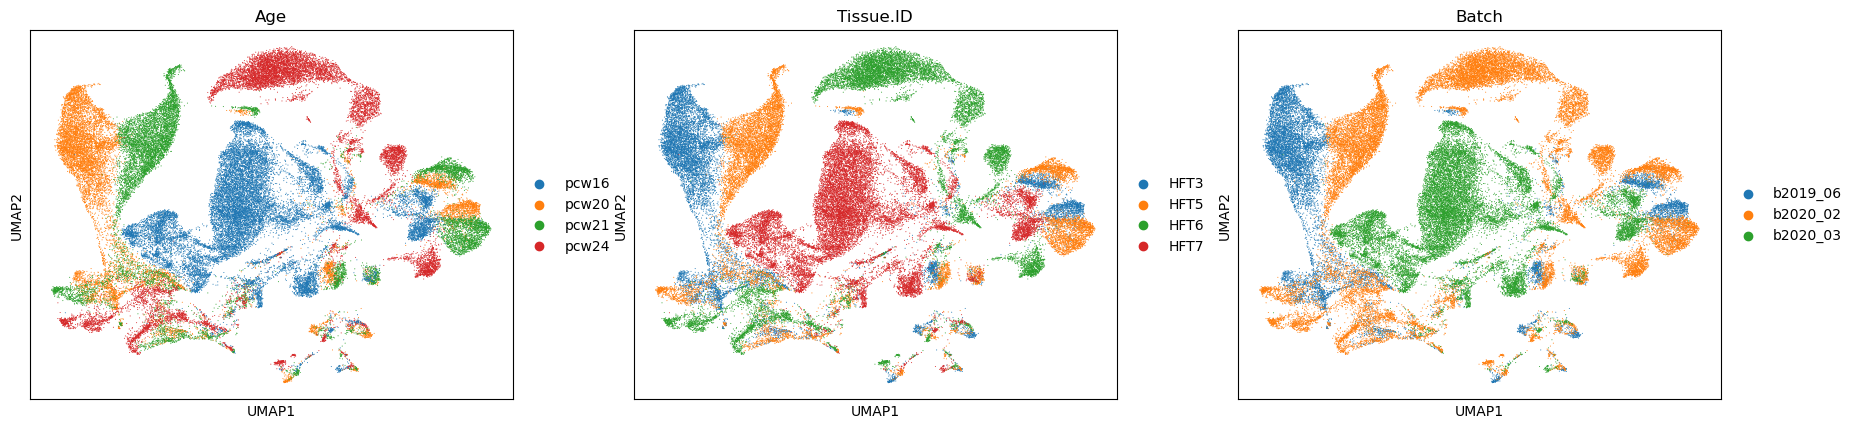

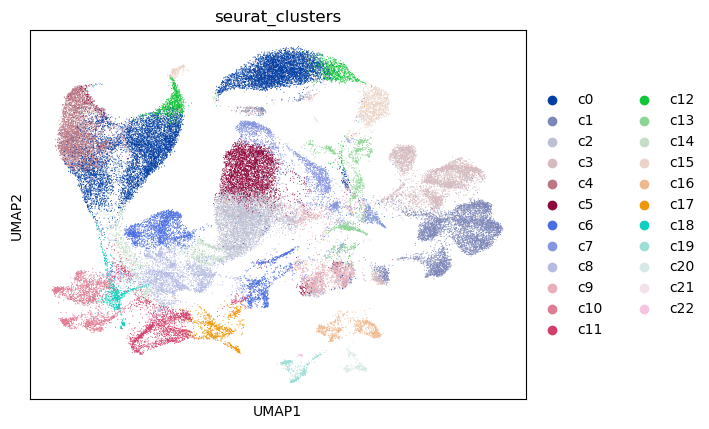

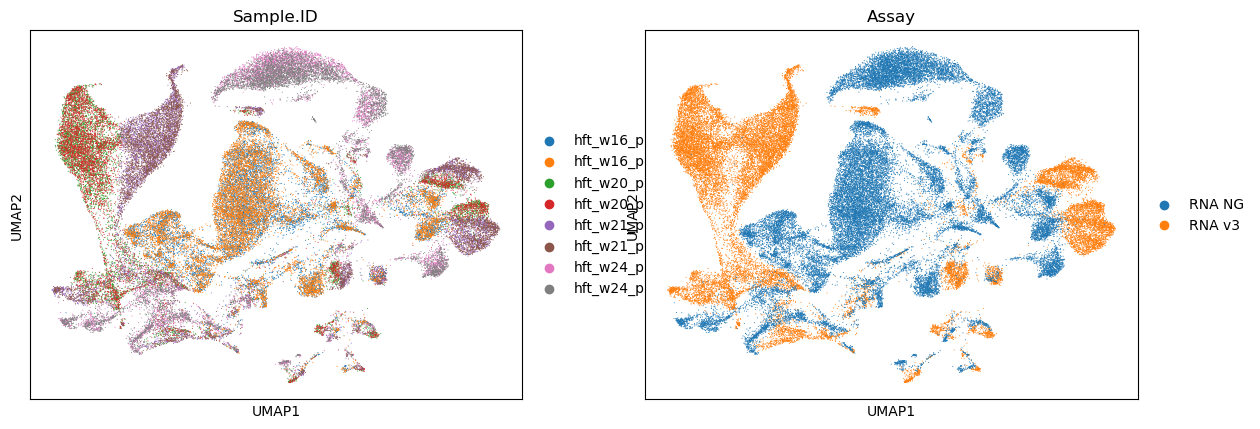

In [4]:
# seurat_clusters are the clustering from the original manuscript
sc.pl.umap(
    adata,
    color = ["Age","Tissue.ID","Batch"]
)

sc.pl.umap(
    adata,
    color = ["seurat_clusters"]
)

sc.pl.umap(
    adata,
    color = ["Sample.ID","Assay"]
)


In [5]:
# obvious batch effects
# We will batch correct with scvi's deep generate modeling
scvi._settings.ScviConfig.seed = 13874
scvi.model.SCVI.setup_anndata(adata, layer = "counts",batch_key = "Sample.ID")
scvi_model = scvi.model.SCVI(adata, n_layers=2, n_latent=30, n_hidden=128, gene_likelihood='nb')
scvi_model.train()


An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/scott/miniconda3/envs/Cortex_development_multiomics/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to imp

Epoch 140/140: 100%|██████████| 140/140 [15:37<00:00,  6.68s/it, v_num=1, train_loss_step=6.05e+3, train_loss_epoch=6.2e+3]

`Trainer.fit` stopped: `max_epochs=140` reached.


Epoch 140/140: 100%|██████████| 140/140 [15:37<00:00,  6.69s/it, v_num=1, train_loss_step=6.05e+3, train_loss_epoch=6.2e+3]


In [6]:
scvi_model

SCVI model with the following parameters: 
n_hidden: 128, n_latent: 30, n_layers: 2, dropout_rate: 0.1, dispersion: gene, gene_likelihood: nb, 
latent_distribution: normal.
Training status: Trained
Model's adata is minified?: False

In [7]:
# save outputs from scvi
adata.obsm['X_scvi'] = scvi_model.get_latent_representation()
adata.layers['counts_scvi'] = scvi_model.get_normalized_expression(library_size=10000)

In [8]:
# cluster
sc.pp.neighbors(adata, use_rep='X_scvi', key_added='neighbors_scvi', n_neighbors=20)
sc.tl.leiden(adata, neighbors_key='neighbors_scvi', key_added='leiden_scvi', resolution=1, flavor="igraph", n_iterations=2)

sc.tl.umap(adata, neighbors_key='neighbors_scvi')

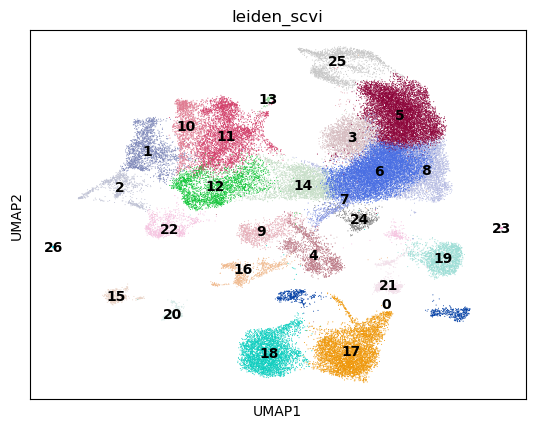

In [9]:
sc.pl.umap(adata, color=['leiden_scvi'], legend_loc='on data')

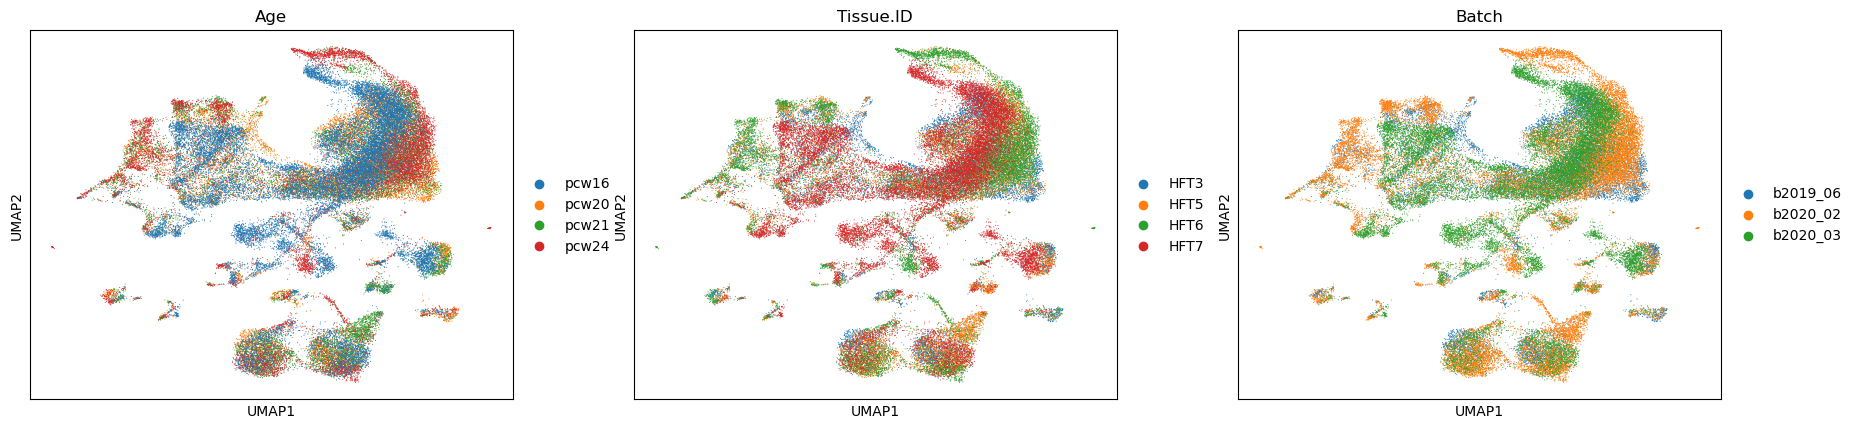

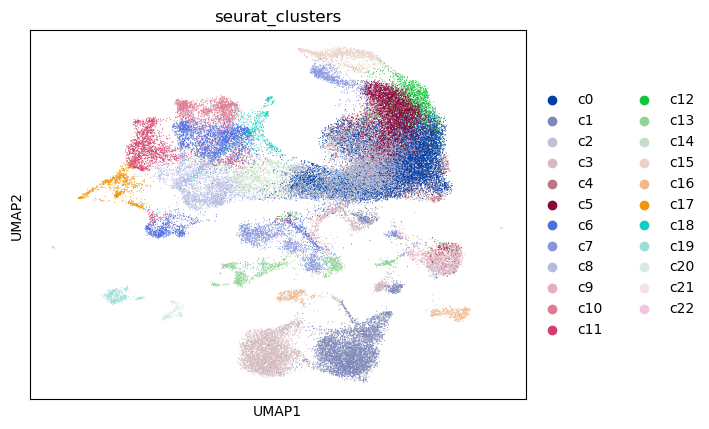

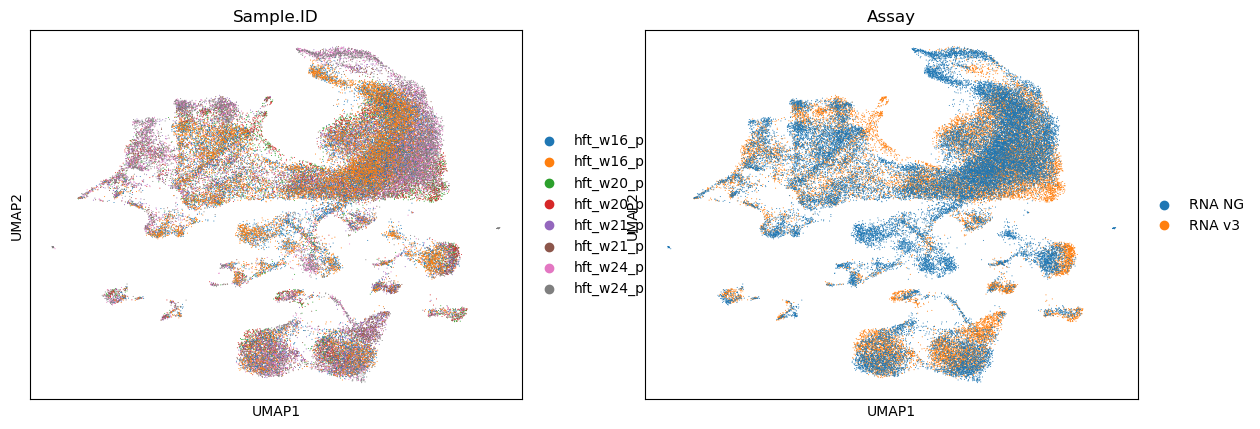

In [10]:
sc.pl.umap(
    adata,
    color = ["Age","Tissue.ID","Batch"]
)

sc.pl.umap(
    adata,
    color = ["seurat_clusters"]
)

sc.pl.umap(
    adata,
    color = ["Sample.ID","Assay"]
)

In [11]:
# save output
write_h5ad_path = "data/processed_data/clustered_rna.h5ad"
adata.write_h5ad(write_h5ad_path)